In [1]:
# 이미 lms 클라우드에서 실행함.

# !mkdir -p ~/aiffel/chest_xray
# !ln -s ~/data/ ~/aiffel/chest_xray

https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

In [2]:
# 필요한 라이브러리 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Step1. 실험 환경 set-up

In [3]:
# 앞으로 필요한 변수들을 생성.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변경해야 할 변수들.. (실험적으로)
BATCH_SIZE = 8 # 이전 16인 배치 사이즈 역시 좀더 작게 진행! (근거는 아래 주석)
EPOCHS = 30 # 이전 학습에서는 25를 사용 에포크를 5정도 늘려봄

print(ROOT_PATH)



/aiffel/aiffel


## batch size를 반토막 낸 이유

실제 학습 과정에 있어서 더 큰 batch size를 골랐을 때 다양한 데이터에 “일반화”함에 있어서 모델의 성능이 눈에 띄게 하락하는 것이 확인되었다.
(2016) 큰 batch size가 주어진 상황에서의 일반화 성능이 하락하는 이유를 정확히 설명하기 위한 시도는 여러 방면에서 이루어졌지만, 이 현상의 정확한 이유는 아직까지 알려지지 않았다.

reference : https://nyanye.com/paper/2020/05/30/good-batchsize/

### set별 데이터 분포

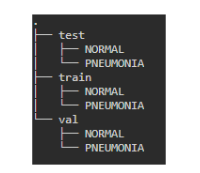

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 5216개, test는 624개, val안에는 16개가 있다.

개수비를 비교하면 val이 0.3%로 너무 턱없이 부족해서 training dataset에서 validation으로 데이터를 가져온다.

train:val = 8:2로 분할한다.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 결로에 normal이 있는지 확인하면 정상이미지 카운팅 가능. 폐렴도 역시 가능.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


Minibatch는 왜 사용하는가? 

https://acdongpgm.tistory.com/202

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA' # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지의 사이즈를 맞춰주는 역할이 필요하다.

In [12]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 read
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label
    
    

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape: (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화
show_batch()함수를 이용해서 사진 도출

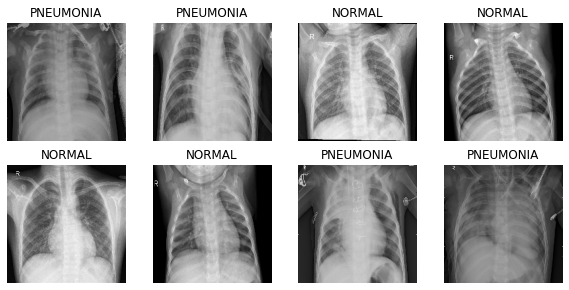

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/2),n+1) # 4 -> 2로 변경
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

http://taewan.kim/post/cnn/

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
# Dense Block은 아래와 같이 만듭니다.

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fopenaccess.thecvf.com%2Fcontent_CVPR_2019%2Fpapers%2FLi_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf&clen=1272425&chunk=true

Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Farxiv.org%2Fpdf%2F1905.05928.pdf&clen=856720&chunk=true

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Imbalance 데이터 처리

https://3months.tistory.com/414

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
optimizer로 'adam'을 사용
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
523/523 [==============================] - 64s 98ms/step - loss: 0.4471 - accuracy: 0.7813 - precision: 0.9378 - recall: 0.7561 - val_loss: 1.2948 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/30
523/523 [==============================] - 51s 97ms/step - loss: 0.3183 - accuracy: 0.8619 - precision: 0.9597 - recall: 0.8499 - val_loss: 0.5427 - val_accuracy: 0.8173 - val_precision: 0.9983 - val_recall: 0.7526
Epoch 3/30
523/523 [==============================] - 50s 96ms/step - loss: 0.3010 - accuracy: 0.8795 - precision: 0.9605 - recall: 0.8740 - val_loss: 0.5362 - val_accuracy: 0.8298 - val_precision: 0.8175 - val_recall: 0.9895
Epoch 4/30
523/523 [==============================] - 51s 97ms/step - loss: 0.2915 - accuracy: 0.8843 - precision: 0.9611 - recall: 0.8802 - val_loss: 0.1319 - val_accuracy: 0.9577 - val_precision: 0.9569 - val_recall: 0.9869
Epoch 5/30
523/523 [==============================] - 52s 99ms/step - loss: 0.2687 - accuracy: 0

## 결과 확인

이제 결과를 확인한다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 추적가능



## BATCH_SIZE = 8
## EPOCHS = 30

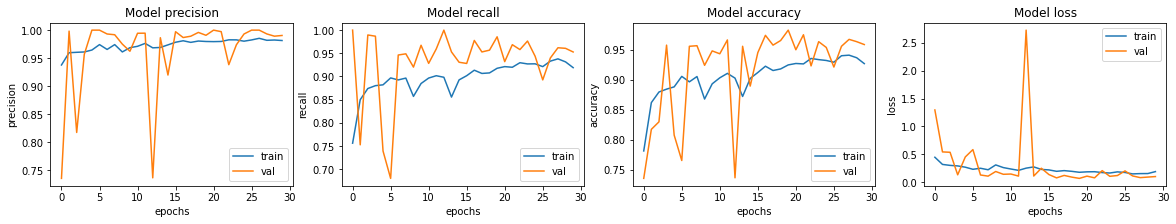

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 4s 54ms/step - loss: 0.6264 - accuracy: 0.8061 - precision: 0.7706 - recall: 0.9821
Loss: 0.6263623237609863,
Accuracy: 0.8060897588729858,
Precision: 0.7706237435340881,
Recall: 0.9820512533187866


## 아래 데이터는 

## BATCH_SIZE = 16  
## EPOCHS = 25   

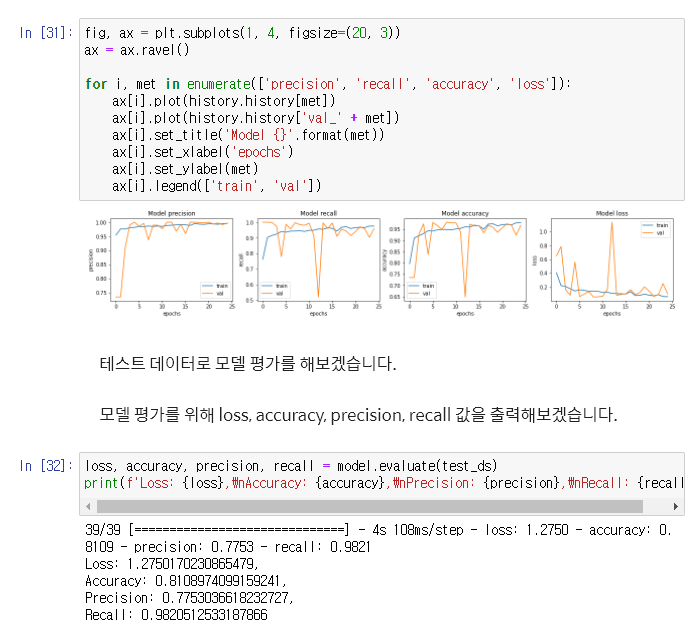

단순하게 배치사이즈를 1/2로 하고 epoch를 조금 근사하게 더 늘린다고 해서 ( 5 늘림)
accuracy 자체는 오히려 근소하게 더 떨어졌다. 81% -> 80%
정확도나 recall값(재현율) 또한 거의 차이가 없었는데, 본 모델 훈련에서는 효과 자체가 미비하였다.

# Step 2. 데이터 준비하기


데이터 증강 기법 (augmentation 기법)을 통해서 데이터가 부족한 경우 데이터를 늘릴수 있는데, 항상 신중하여야 한다. 특히 본 x-ray로 폐렴 판독은 식별이 단순하지만, (단지, 폐 사진 자체가 뿌옇냐 맑냐의 차이니..) 만약 CT에서의 암 판독이나 더 나아가 MRI에서 인대 파열 판독등 고차원적인 판독에서의 잘못된 augmentation은 정확성을 떨어뜨리고 생명을 살리는 의료 진단 분야에서는 심각하게 왜곡된 결과로 이어지면, 겉잡을수 없는 일이 벌어 지고 만다. 

그래서 좌우 반전 정도의 augmentation을 도입하여 다시 run을 해보지만, augmentation 기법등은 정말 향후 의료진단 기업에 취업을 하거나 병원에 취업을 하게 된다면 실무에서 경험을 쌓는 방법 밖에는 실력을 늘릴수 없을것이고 교과서적으로 배우는 것에는 분명 한계가 존재한다는 점을 느끼고 있다.

In [28]:
# 앞으로 필요한 변수들을 생성.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변경해야 할 변수들.. (실험적으로)
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)



/aiffel/aiffel


In [29]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [30]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [31]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [32]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [33]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [34]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [35]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA' # 폐렴이면 양성(True), 노말이면 음성(False)

In [36]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 read
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label
    

In [37]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [38]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape: (180, 180, 3)
Label:  False


In [39]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


# Step 3. 데이터 시각화

## 좌우 반전 도입

In [40]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

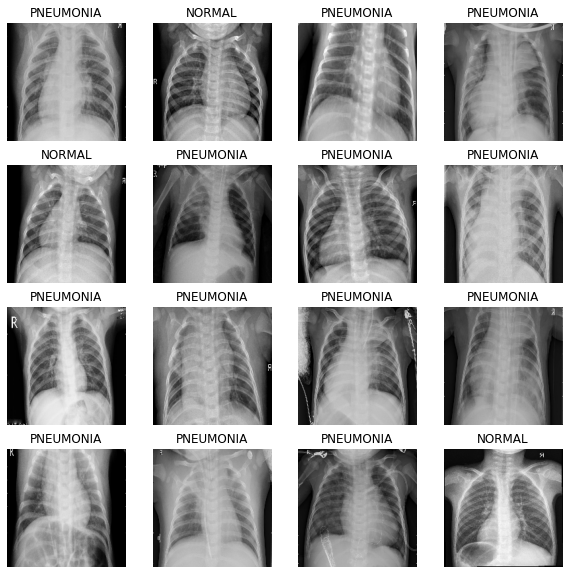

In [41]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 아래쪽이 원본 데이터

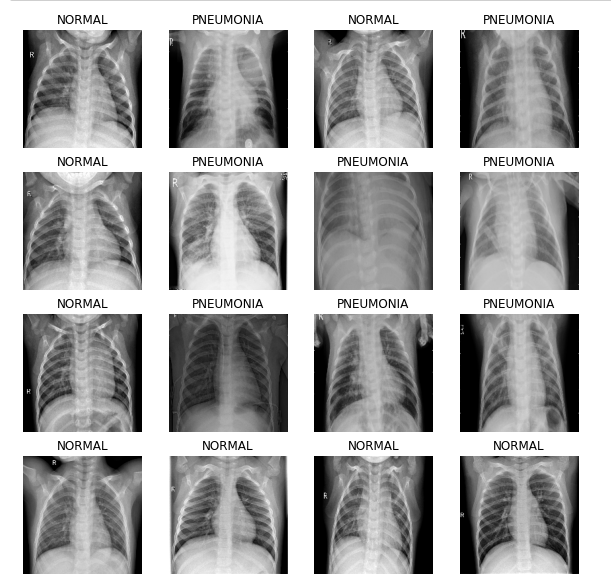

좌우 반전이 일어났음을 확인할 수 있다. 이후에는 똑같이 진행해서 accuracy, recall 등을 check!

In [42]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [46]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [47]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 189ms/step - loss: 0.4552 - accuracy: 0.7696 - precision: 0.9474 - recall: 0.7308 - val_loss: 0.5992 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2738 - accuracy: 0.8843 - precision: 0.9663 - recall: 0.8753 - val_loss: 0.7236 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2302 - accuracy: 0.9059 - precision: 0.9692 - recall: 0.9021 - val_loss: 0.2099 - val_accuracy: 0.9038 - val_precision: 0.8858 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1924 - accuracy: 0.9234 - precision: 0.9800 - recall: 0.9157 - val_loss: 0.1206 - val_accuracy: 0.9529 - val_precision: 0.9918 - val_recall: 0.9438
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1988 - accura

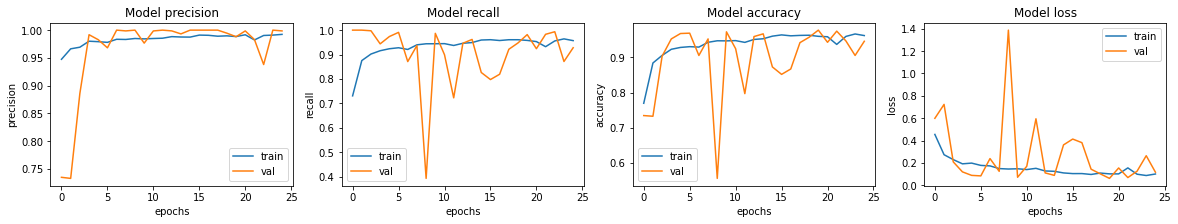

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [49]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 98ms/step - loss: 0.7357 - accuracy: 0.8093 - precision: 0.7805 - recall: 0.9667
Loss: 0.7356564998626709,
Accuracy: 0.8092948794364929,
Precision: 0.7805383205413818,
Recall: 0.9666666388511658


Data에서 좌우 변환을 해도 Accuracy 자체는 거의 그대로인 결과가 나왔다.

# Step 4. CNN 모델링

정확도를 높이기 위해서 여러가지를 수행할 수 있다.

모델 설계에서의 Convolution filter, 채널 개수, activation, 모델구조등을 바꿀수 있다.

추가적으로 BatchNormalization과 Dropout을 한 모델안에서 동시에 사용하는 특이한 구성을 했는데, 각각 1개씩만 쓰거나 아예 안쓰게 할수도 있는 경우의 수도 해볼 예정이다.

그리고 2개 동시에 쓴 상황에서 Dropout의 비율도 변경해볼 예정이다.

In [1]:
# 다시 import
# 필요한 라이브러리 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# 앞으로 필요한 변수들을 생성.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변경해야 할 변수들.. (실험적으로)
BATCH_SIZE = 16 # 이전 배치 사이즈
EPOCHS = 25 # 이전 에포크
print(ROOT_PATH)

/aiffel/aiffel


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA' # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 read
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape: (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화
show_batch()함수를 이용해서 사진 도출

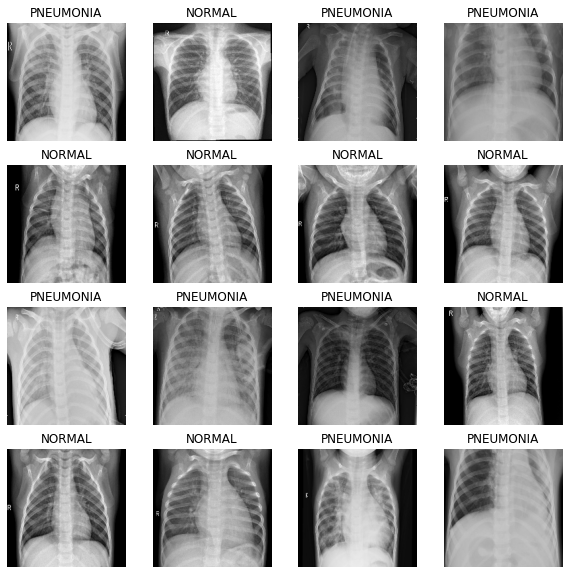

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1) 
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 본격적인 CNN 모델링

### Dropout 0.2 -> 0.5로 ratio 증가 (과대적합 막기용)

함수형 API 만들기

In [42]:

# Convolution Block의 구성은 Convolution을 2번 진행하고,
# Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다.
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block 제작

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
from keras.layers import LeakyReLU

def build_model(): # conv_block, dense_block의 값들을 조정
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'), 
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 비율 0.2 -> 0.5로 변경
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 비율 0.2 -> 0.5로 변경
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') # 이진분류라서 sigmoid 사용
    ])
    
    return model

 데이터 imbalance 처리

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


모델 훈련

In [46]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 188ms/step - loss: 0.0675 - accuracy: 0.9794 - precision: 0.9951 - recall: 0.9771 - val_loss: 0.1441 - val_accuracy: 0.9548 - val_precision: 0.9986 - val_recall: 0.9398
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.0835 - accuracy: 0.9693 - precision: 0.9940 - recall: 0.9646 - val_loss: 0.0952 - val_accuracy: 0.9644 - val_precision: 1.0000 - val_recall: 0.9516
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.0669 - accuracy: 0.9773 - precision: 0.9954 - recall: 0.9739 - val_loss: 0.3885 - val_accuracy: 0.9510 - val_precision: 0.9429 - val_recall: 0.9935
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9951 - recall: 0.9765 - val_loss: 0.2557 - val_accuracy: 0.9000 - val_precision: 0.9955 - val_recall: 0.8678
Epoch 5/25
261/261 [==============================] - 50s 190ms/step - loss: 0.0754 - accura

결과 확인

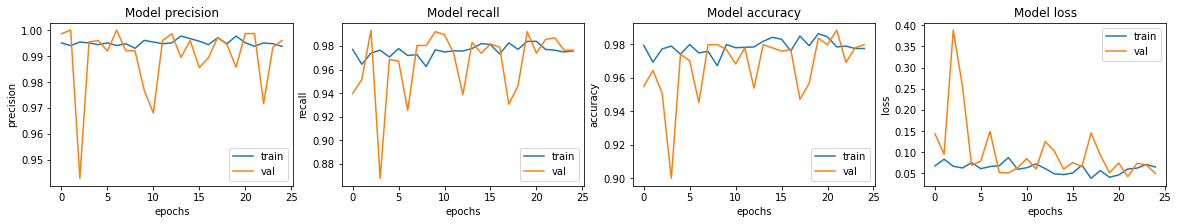

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall 값 확인

In [51]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.0615 - accuracy: 0.8205 - precision: 0.7802 - recall: 0.9923
Loss: 1.0614607334136963,
Accuracy: 0.8205128312110901,
Precision: 0.7802419066429138,
Recall: 0.9923076629638672


Dropout의 비중을 늘리니 (0.2 -> 0.5) 1프로 정도 Accuracy가 근소하게나마 상승하였다. 

### activation function RELU -> LEAKYRELU로 변경

In [87]:
# from keras.layers import LeakyReLU
# LeakyReLU = tf.nn.leaky_relu
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
from keras.layers.advanced_activations import LeakyReLU

In [88]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # LeakyReLU로 변경
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [89]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [90]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [91]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [93]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [94]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 191ms/step - loss: 0.3165 - accuracy: 0.8558 - precision: 0.9696 - recall: 0.8323 - val_loss: 0.6950 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2069 - accuracy: 0.9183 - precision: 0.9756 - recall: 0.9130 - val_loss: 1.3546 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1555 - accuracy: 0.9437 - precision: 0.9819 - recall: 0.9418 - val_loss: 0.1310 - val_accuracy: 0.9404 - val_precision: 0.9270 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1441 - accuracy: 0.9478 - precision: 0.9839 - recall: 0.9453 - val_loss: 0.0674 - val_accuracy: 0.9779 - val_precision: 0.9882 - val_recall: 0.9817
Epoch 5/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1426 - accura

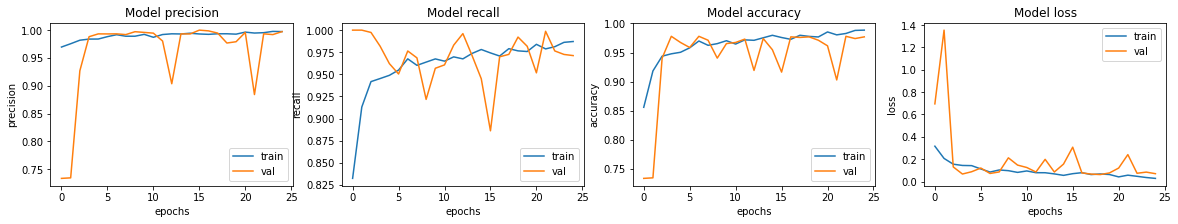

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [96]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 101ms/step - loss: 0.9822 - accuracy: 0.8189 - precision: 0.7844 - recall: 0.9795
Loss: 0.9821792840957642,
Accuracy: 0.8189102411270142,
Precision: 0.7843942642211914,
Recall: 0.9794871807098389


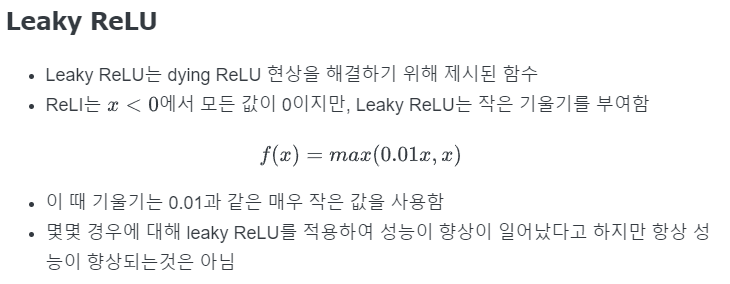

https://seongkyun.github.io/study/2019/05/01/activations/

Leaky ReLU를 사용하였지만, 성능 향상을 보지는 못하였다.

## BatchNormalization 사용x, Dropout만 사용

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

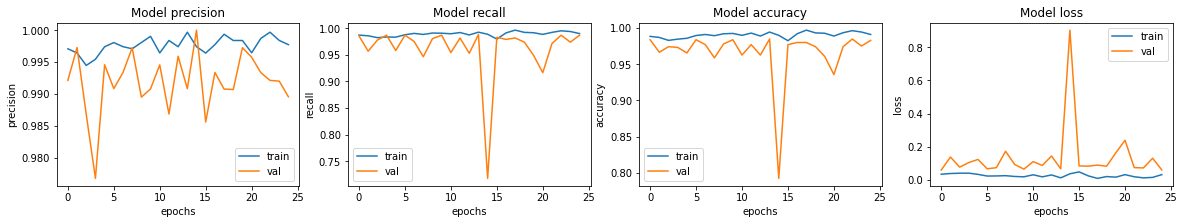

In [110]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [111]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 186ms/step - loss: 1.1046 - accuracy: 0.7532 - precision: 0.7169 - recall: 1.0000
Loss: 1.1045643091201782,
Accuracy: 0.7532051205635071,
Precision: 0.716911792755127,
Recall: 1.0


Dropout만 사용했을때의 결과는 accuracy 75%가 나왔다.

## BatchNormalization 사용, Dropout X

In [117]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [118]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [119]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0), # dropout 사용 x
        
        conv_block(256),
        tf.keras.layers.Dropout(0),  # dropout 사용 x
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0),        # dropout 사용 x
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [120]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [121]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [122]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 190ms/step - loss: 0.2187 - accuracy: 0.9088 - precision: 0.9749 - recall: 0.9005 - val_loss: 0.6866 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 186ms/step - loss: 0.1634 - accuracy: 0.9370 - precision: 0.9788 - recall: 0.9356 - val_loss: 1.1010 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1401 - accuracy: 0.9500 - precision: 0.9846 - recall: 0.9476 - val_loss: 0.1605 - val_accuracy: 0.9327 - val_precision: 0.9241 - val_recall: 0.9895
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1091 - accuracy: 0.9581 - precision: 0.9893 - recall: 0.9540 - val_loss: 0.1776 - val_accuracy: 0.9500 - val_precision: 0.9945 - val_recall: 0.9373
Epoch 5/25
261/261 [==============================] - 49s 190ms/step - loss: 0.0921 - accura

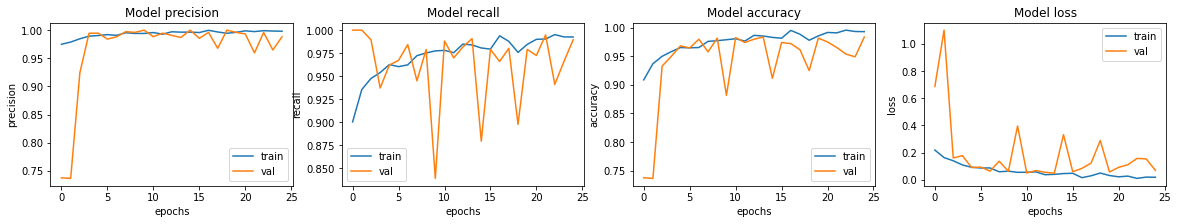

In [123]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [124]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 1.8342 - accuracy: 0.7388 - precision: 0.7067 - recall: 0.9949
Loss: 1.8341635465621948,
Accuracy: 0.7387820482254028,
Precision: 0.7067395448684692,
Recall: 0.9948717951774597


BatchNorm만 사용했을때의 accuracy는 73프로로 다소 감소하였다.

## BatchNormalization X, Dropout X

In [125]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [126]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [127]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0),
        
        conv_block(256),
        tf.keras.layers.Dropout(0),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0),
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [128]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [129]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [130]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 211ms/step - loss: 0.6939 - accuracy: 0.4804 - precision: 0.7432 - recall: 0.4597 - val_loss: 0.6923 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 182ms/step - loss: 0.6921 - accuracy: 0.6470 - precision: 0.7426 - recall: 0.8056 - val_loss: 0.6927 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 182ms/step - loss: 0.6942 - accuracy: 0.6700 - precision: 0.7373 - recall: 0.8633 - val_loss: 0.6931 - val_accuracy: 0.2635 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 47s 181ms/step - loss: 0.6940 - accuracy: 0.5055 - precision: 0.7385 - recall: 0.5179 - val_loss: 0.6943 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 48s 184ms/step - loss:

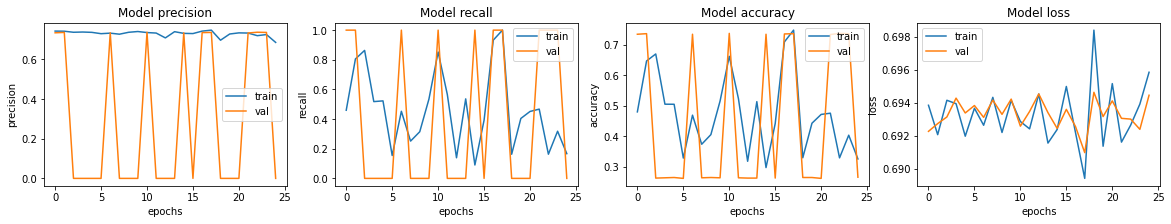

In [131]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [132]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.6939 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6938547492027283,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


BatchNorm과 Dropout을 다 없애니 엉망인 결과가 나왔다.

# Step 5. 데이터 imbalance 처리

Data imbalance 문제를 생각하지 않고 class_weight의 설정을 생략한 결과도 고려해 본다.
+ recall을 강조하기 위한 효과 

https://sdpcs.tistory.com/6

https://box-world.tistory.com/24

In [133]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [134]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [135]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [136]:
# class_weight 없애기

# weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
# print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [137]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [138]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
#         class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 184ms/step - loss: 0.3942 - accuracy: 0.8341 - precision: 0.9307 - recall: 0.8393 - val_loss: 0.8801 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 180ms/step - loss: 0.2242 - accuracy: 0.9222 - precision: 0.9505 - recall: 0.9446 - val_loss: 1.1654 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1964 - accuracy: 0.9284 - precision: 0.9492 - recall: 0.9550 - val_loss: 0.9308 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1751 - accuracy: 0.9375 - precision: 0.9575 - recall: 0.9584 - val_loss: 0.3187 - val_accuracy: 0.8740 - val_precision: 0.9969 - val_recall: 0.8312
Epoch 5/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1507 - accura

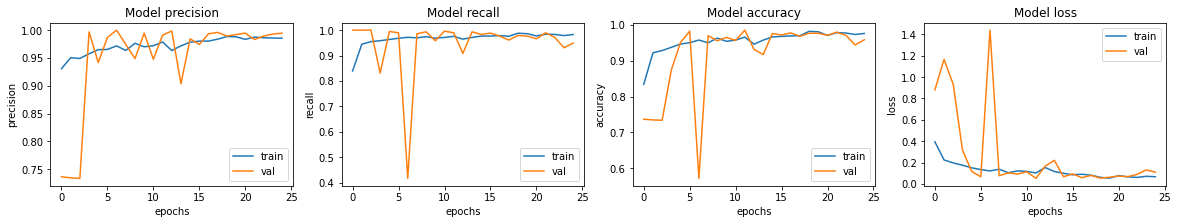

In [139]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [140]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 0.6665 - accuracy: 0.8750 - precision: 0.8498 - recall: 0.9718
Loss: 0.6665105223655701,
Accuracy: 0.875,
Precision: 0.8497757911682129,
Recall: 0.971794843673706


imbalance 처리를 하지 않으니 accuracy는 대폭 향상이 되었다. Recall값도 97%가 나왔다.
예상치 못하게 높은 정확성이 나왔다.

# Step 6. 모델 훈련

optimizer의 종류도 많고, 각각의 optimizer에서의 basic으로 셋팅된 learning rate도 있는데 변화를 줄수 있다. 

가장 진보한 Nadam이나 Adam으로 진행하면서 learning rate를 변화시켜볼 예정이다.

(SGD, Momentum, NAG, Adagrad, RMSProp 등을 다 하면 시간이 엄청 소요되므로.. )

LeakyRELU 적용하고, Dropout 0.5로 증가 시킨 상태를 default값으로 적용!

정확성 85%에 근접하게 달성하는 것이 목표

### Optimiezer 특징 정리 :

https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%97%B4%EC%97%AC%EC%84%AF-%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-8a6cc162fd8


### 조건 :

활성화 함수 : LeakyReLU
Conv_block 에서 dropout ratio 0.2 -> 0.5로 상향
Optimizer : Nadam

Optimizer란 경사하강법에서 오차를 어떻게 줄여나갈지 정하는 함수를 의미한다.

Nadam은 Adam에다가 네스테로프 모멘텀(NAG)를 결합한 방식

NAG란? 모멘텀이 이동시킬 방향으로 미리 이동해서 gradient를 계산, 불필요한 이동을 줄이는 효과를 준다.

Adam이란? Momentum과 RMSProp을 합친 방법으로 정확도와 보폭크기를 개선한 것이다.

쉽게 얘기해서 Nadam이 검증된 가장 진보한 Optimizer이다.

Nadam은 Adam과 NAG의 장점을 합쳤기 때문에 Adam보다 좀 더 빠르고 정확하게 전역 최솟값(global minimum)을 찾아낼 수 있다는 장점이 있다.

기계학습 옵티마이저 성능평가 논문
reference : 

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.koreascience.or.kr%2Farticle%2FJAKO202029462558311.pdf&clen=802071




추가적으로 accuracy가 목표까지 도달하지 못하면 epoch를 늘려서 진행하고 학습률은 0.001로 default로 설정하여 0.1까지 x10을 하여 3 set로 구성하여 진행을 해볼 예정이다.

학습률이 낮으면 최솟값으로 곧장 최적화 되지 못하고 지그재그로 이동하게 되면서 local minimum에 빠질수 있으며, 또 너무 높게 설정이 되면 최적화를 실패할 수 있다는 단점이 존재하므로, 적절한 설정값을 찾아보기 위한 계획이다.

In [141]:
from keras.layers.advanced_activations import LeakyReLU

In [142]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # LeakyReLU로 변경
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [143]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [144]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [145]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


learning rate = 0.001

In [147]:
tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

In [148]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Nadam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [149]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 189ms/step - loss: 0.3860 - accuracy: 0.8053 - precision: 0.9545 - recall: 0.7754 - val_loss: 0.6393 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 186ms/step - loss: 0.2430 - accuracy: 0.9035 - precision: 0.9730 - recall: 0.8950 - val_loss: 0.9004 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1900 - accuracy: 0.9286 - precision: 0.9795 - recall: 0.9233 - val_loss: 0.1105 - val_accuracy: 0.9635 - val_precision: 0.9802 - val_recall: 0.9699
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1725 - accuracy: 0.9344 - precision: 0.9794 - recall: 0.9315 - val_loss: 0.0612 - val_accuracy: 0.9779 - val_precision: 0.9843 - val_recall: 0.9856
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1449 - accura

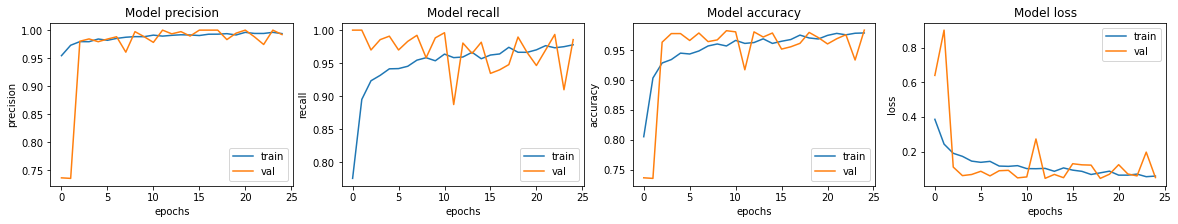

In [150]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [151]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.3061 - accuracy: 0.7853 - precision: 0.7471 - recall: 0.9923
Loss: 1.3060765266418457,
Accuracy: 0.7852563858032227,
Precision: 0.7471042275428772,
Recall: 0.9923076629638672


# Step 7. 결과 확인과 시각화

accuracy, recall 등의 시각화가 중요! 직접 시각화해서 한눈에 보기

In [152]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # LeakyReLU로 변경
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [153]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [154]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [155]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


learning_rate=0.01

In [156]:
tf.keras.optimizers.Nadam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") 

In [157]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Nadam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [158]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 193ms/step - loss: 0.3821 - accuracy: 0.8259 - precision: 0.9577 - recall: 0.8014 - val_loss: 0.6864 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2362 - accuracy: 0.9114 - precision: 0.9717 - recall: 0.9073 - val_loss: 1.0337 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1895 - accuracy: 0.9274 - precision: 0.9749 - recall: 0.9262 - val_loss: 0.0773 - val_accuracy: 0.9788 - val_precision: 0.9806 - val_recall: 0.9908
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1623 - accuracy: 0.9363 - precision: 0.9800 - recall: 0.9333 - val_loss: 0.0690 - val_accuracy: 0.9740 - val_precision: 0.9718 - val_recall: 0.9935
Epoch 5/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1601 - accura

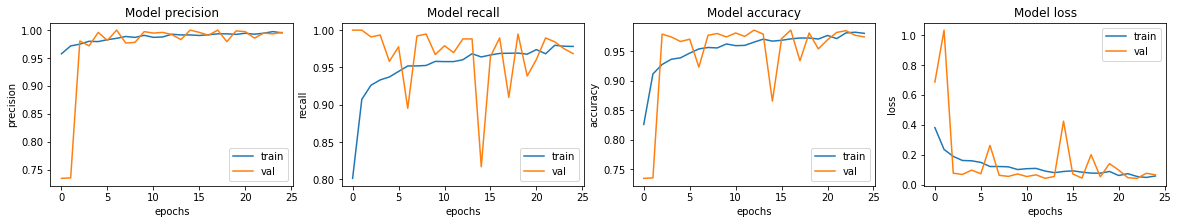

In [159]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [160]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.7808 - accuracy: 0.8125 - precision: 0.7769 - recall: 0.9821
Loss: 0.7807828187942505,
Accuracy: 0.8125,
Precision: 0.7768762707710266,
Recall: 0.9820512533187866


In [161]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


learning_rate=0.1

In [162]:
tf.keras.optimizers.Nadam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") 

In [163]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Nadam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [164]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 191ms/step - loss: 0.4103 - accuracy: 0.7866 - precision: 0.9511 - recall: 0.7518 - val_loss: 0.5814 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2155 - accuracy: 0.9167 - precision: 0.9795 - recall: 0.9070 - val_loss: 0.8588 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2000 - accuracy: 0.9274 - precision: 0.9766 - recall: 0.9247 - val_loss: 0.1286 - val_accuracy: 0.9452 - val_precision: 0.9327 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1725 - accuracy: 0.9351 - precision: 0.9794 - recall: 0.9323 - val_loss: 0.0709 - val_accuracy: 0.9760 - val_precision: 0.9805 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1577 - accura

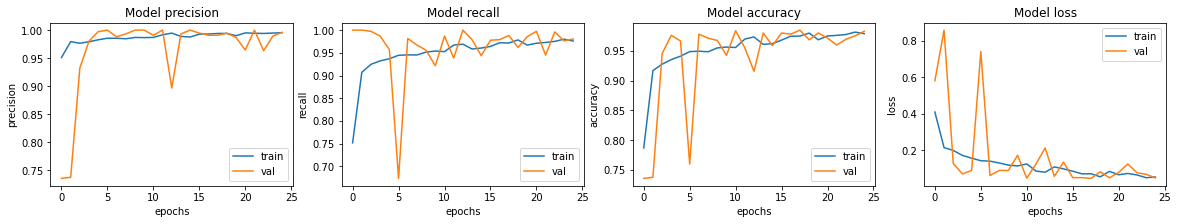

In [165]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [166]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.0598 - accuracy: 0.8077 - precision: 0.7668 - recall: 0.9949
Loss: 1.0598241090774536,
Accuracy: 0.807692289352417,
Precision: 0.7667984366416931,
Recall: 0.9948717951774597


위의 3가지의 learning rate를 살펴보게 된다면 그렇게 크게 영향을 주는것으로 보이지는 않는다. 

조금이라도 accuracy를 증가시키기 위해서는 Epoch 50으로 증가시키고, 미니 배치 크기를 변경하고 은닉층 개수를 늘리는 방법, 그리고 Nadam을 Adam으로 변경하여 시간이 좀 더 걸리지만, 오히려 정확성이 개선된다는 보고 있으니 그렇게 진행을 할 예정이다.

In [167]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # LeakyReLU로 변경
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [168]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [171]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.5), # 0.5 추가

        conv_block(64),
        tf.keras.layers.Dropout(0.5), # 0.5 추가
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),   # dense_block 층 추가
        dense_block(64, 0.3),
        dense_block(32, 0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [172]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [174]:
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="adam") 
# Nadam에서 adam으로 변경하고 learning_rate는 dafault값으로

In [175]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [176]:
EPOCHS = 50 # 에포크 50으로

In [177]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 58s 187ms/step - loss: 0.4639 - accuracy: 0.7498 - precision: 0.9331 - recall: 0.7147 - val_loss: 0.6214 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 50s 190ms/step - loss: 0.2626 - accuracy: 0.8863 - precision: 0.9694 - recall: 0.8749 - val_loss: 1.0872 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 49s 190ms/step - loss: 0.2247 - accuracy: 0.9059 - precision: 0.9695 - recall: 0.9017 - val_loss: 0.1461 - val_accuracy: 0.9404 - val_precision: 0.9303 - val_recall: 0.9935
Epoch 4/50
261/261 [==============================] - 50s 191ms/step - loss: 0.1991 - accuracy: 0.9239 - precision: 0.9758 - recall: 0.9205 - val_loss: 0.1043 - val_accuracy: 0.9596 - val_precision: 0.9524 - val_recall: 0.9948
Epoch 5/50
261/261 [==============================] - 50s 192ms/step - loss: 0.1875 - accura

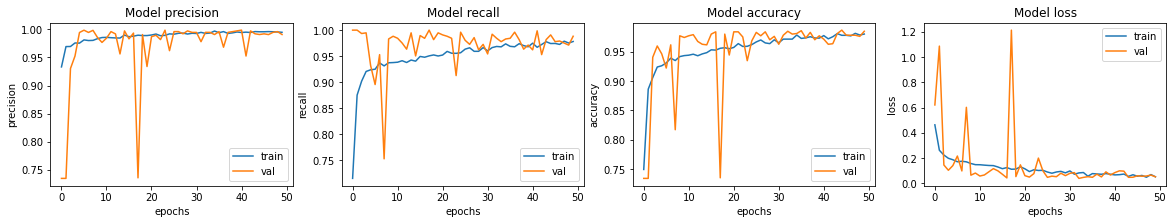

In [178]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [179]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 1.2726 - accuracy: 0.7532 - precision: 0.7169 - recall: 1.0000
Loss: 1.2725698947906494,
Accuracy: 0.7532051205635071,
Precision: 0.716911792755127,
Recall: 1.0


Image Augmentation(이미지 증식) : https://ysyblog.tistory.com/152

아래 글을 토대로 batch size까지 변경해서 다시 모델을 훈련해서 평가하려고 한다.

https://inhovation97.tistory.com/32

    batch size 32,
    epoch = 25

In [180]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # LeakyReLU로 변경
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [181]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [182]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.5), # 0.5 추가

        conv_block(64),
        tf.keras.layers.Dropout(0.5), # 0.5 추가
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 0.5
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),   # dense_block 층 추가
        dense_block(64, 0.3),
        dense_block(32, 0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [183]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [184]:
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="adam") 
# Nadam에서 adam으로 변경하고 learning_rate는 dafault값으로

In [185]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [186]:
EPOCHS = 25 # 50 -> 25
BATCH_SIZE = 32 # 8 -> 32 (batch size를 2배하니, iteration이 1/2이 됨)

In [187]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 38s 219ms/step - loss: 0.6082 - accuracy: 0.6582 - precision: 0.8850 - recall: 0.6214 - val_loss: 0.6226 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 27s 211ms/step - loss: 0.3378 - accuracy: 0.8288 - precision: 0.9656 - recall: 0.7983 - val_loss: 0.6258 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 27s 211ms/step - loss: 0.3007 - accuracy: 0.8760 - precision: 0.9619 - recall: 0.8697 - val_loss: 0.9116 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 28s 217ms/step - loss: 0.2688 - accuracy: 0.8899 - precision: 0.9669 - recall: 0.8802 - val_loss: 0.7790 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 29s 226ms/step - loss: 0.2404 - accura

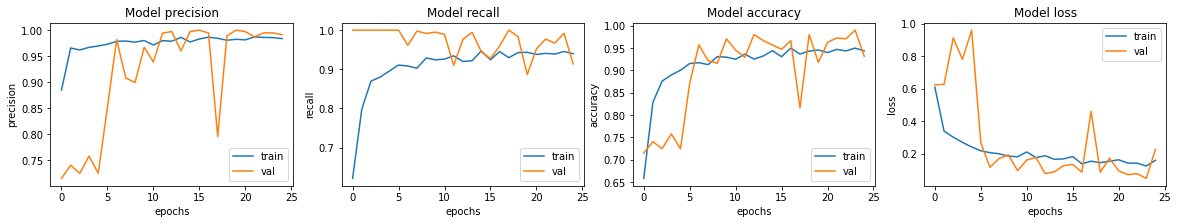

In [188]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [189]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.5961 - accuracy: 0.8365 - precision: 0.8288 - recall: 0.9308
Loss: 0.5960975289344788,
Accuracy: 0.8365384340286255,
Precision: 0.8287671208381653,
Recall: 0.9307692050933838


In [190]:
BATCH_SIZE = 64 # 32 -> 64 (batch size를 2배하니, iteration이 1/2이 됨)

In [191]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 23s 260ms/step - loss: 0.1082 - accuracy: 0.9558 - precision: 0.9945 - recall: 0.9452 - val_loss: 0.0930 - val_accuracy: 0.9648 - val_precision: 0.9944 - val_recall: 0.9568
Epoch 2/25
65/65 [==============================] - 17s 268ms/step - loss: 0.1249 - accuracy: 0.9538 - precision: 0.9894 - recall: 0.9491 - val_loss: 0.2396 - val_accuracy: 0.9102 - val_precision: 1.0000 - val_recall: 0.8789
Epoch 3/25
65/65 [==============================] - 17s 270ms/step - loss: 0.1668 - accuracy: 0.9452 - precision: 0.9822 - recall: 0.9422 - val_loss: 0.0747 - val_accuracy: 0.9609 - val_precision: 0.9554 - val_recall: 0.9948
Epoch 4/25
65/65 [==============================] - 18s 284ms/step - loss: 0.1153 - accuracy: 0.9529 - precision: 0.9893 - recall: 0.9473 - val_loss: 0.1425 - val_accuracy: 0.9258 - val_precision: 0.9943 - val_recall: 0.9058
Epoch 5/25
65/65 [==============================] - 19s 289ms/step - loss: 0.1372 - accuracy: 0.9413

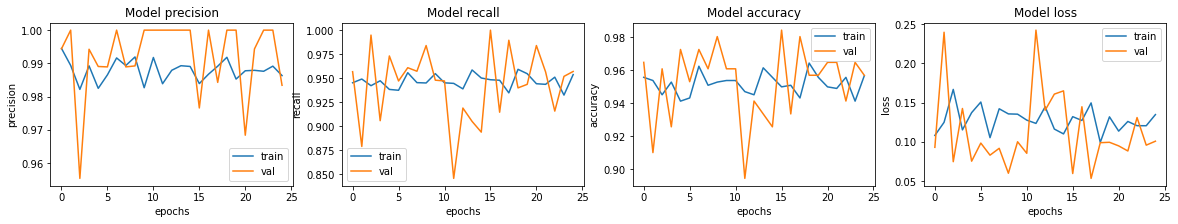

In [192]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [193]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.7123 - accuracy: 0.7965 - precision: 0.7646 - recall: 0.9744
Loss: 0.7122611999511719,
Accuracy: 0.7964743375778198,
Precision: 0.7645875215530396,
Recall: 0.9743589758872986


결국 batch_size가 적당해야 하며 너무 커도 정확성이 떨어지는 문제가 발생하는것을 확인했다.

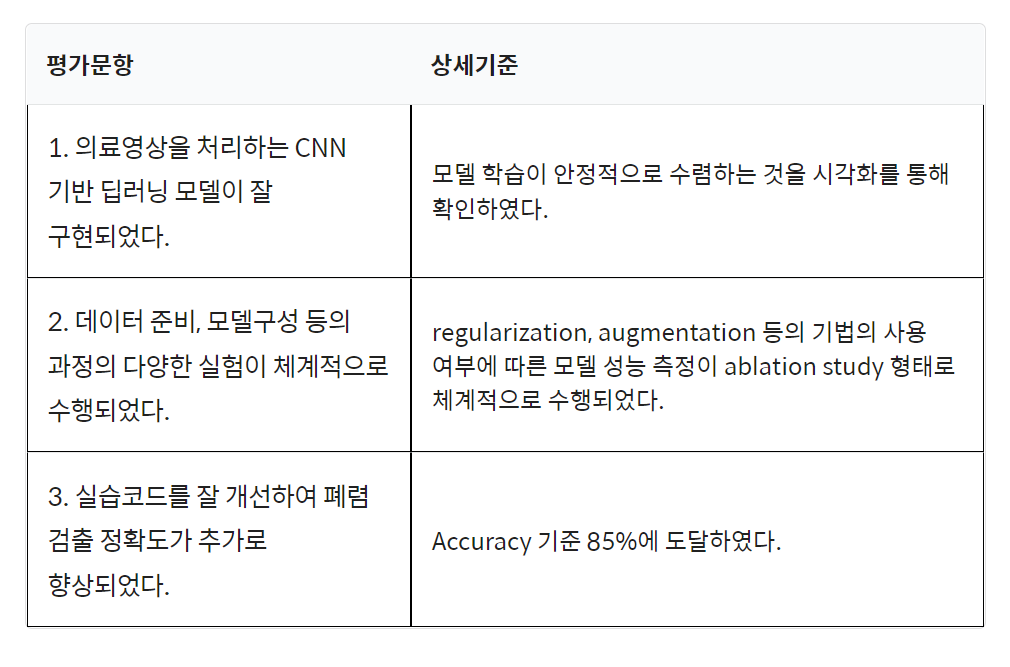

루브릭 기준에서 1. 기준은 통과하였고 2. 역시 ablation study를 통하여 cnn에서 몰랐던 부분들을 하나하나 확인할수 있었다.
다만, data augmentation이라던지 이러한 부분을 통해서 데이터 증강을 하여 학습을 하였으면 Accuracy가 더 개선되지 않았을까 생각이 들었다.
의외로 learning rate라던지 optimizer 등은 영향을 거의 미치지 않았는데, 흥미로웠던 점은

배치 정규화(Batch Normalization) 없이 dropout만 했을때의 조건에서 recall 값이 1이 나왔다는 것이었다.
사실 recall값은 암을 진단하는 경우나 폐렴진단같은 의료진단시 중요한 부분인데, 오차행렬에서 양성을 음성(FN)으로 판단하면 안되기에 중요한 지표로 사용되는 값이다.

배치 정규화라는 개념은 정확히 평균과 분산을 조정하는 과정이 별도의 과정으로 떼어진 것이 아니라, 신경망 안에 포함되어 학습 시 평균과 분산을 조정하는 과정이라고 보면 되는데, 도대체 어떠한 영향을 끼쳤길래 저런 결과가 나온건지 궁금하다.

3. 기준에서 85%까지 도달하지는 못하였으나, 83.6%까지는 도달하였는데, 아마 시도하지 못한 data augmentaion을 수행하였으면 충분히 그 이상 넘어가지 않았을까라고 회고해본다.

이번 explororation을 통해서 cnn 전반에 대한 이해도가 높아졌는데, NLP와 cv도 복습을 하여 이해도를 높여야 겠다.
